In [39]:
import pandas as pd
import numpy as np
import re
import matplotlib.pyplot as plt
import wordninja
import nltk
import itertools
import seaborn as sns
flatten = itertools.chain.from_iterable
pd.set_option('mode.chained_assignment', None)

In [2]:
pd.options.display.max_rows = None
pd.options.display.max_columns = None

In [3]:
data = pd.read_csv('final_data.csv')
df = data.copy()

In [4]:
df.loc[df['num_reviews'] == 'No review','num_reviews'] = 0
df['num_reviews'] = df['num_reviews'].astype(int)

In [5]:
df.head()

,header,price_cad,sales,seller,details,description,availability,num_reviews
0,ZERO | paracord men/women fashion bracelet,8.18,121.0,blacksquirrel2019,"['Handmade item', 'Materials: Nylon', 'Adjusta...",ZERO by BlackSquirrel is an ultra-minimal brac...,In stock,26
1,Black Paracord Survival Bracelet w/ Fishing Li...,19.99,169.0,SterlingSurvival,"['Handmade item', 'Materials: Plastic', 'Adjus...",**COVID-19 ANNOUNCEMENT: The current global pa...,In stock,20
2,Wide-cuffed Paracord Bracelet!,30.00,1.0,GorillaCordzCanada,"['Handmade item', 'Materials: Paracord', 'Adju...","Durable and rugged enough for the outdoors, st...",In stock,0
3,Stylish Paracord Bracelet,8.75,29.0,BraceletsandbeyondCa,"['Handmade item', 'Materials: Nylon', 'Adjusta...","Stylish Paracord BraceletHandmade""A Must Have""...",In stock,10
4,Paracord 7” Bracelets,6.50,179.0,BrigsSandP,"['Handmade item', 'Materials: Paracord', 'Adju...","Video Game, Character & Dragon Paracord Bracel...",In stock,34


### 1. Extract information from 'details' column

#### made to order

In [5]:
df.loc[df.details.str.contains('Made to Order') == True,'made_to_order'] = 'Yes'
df.loc[df.details.str.contains('Made to Order') == False,'made_to_order'] = 'No'

#### personalized

In [6]:
df.loc[df.details.str.contains('Can be personalised: Yes') == True,'personalised'] = 'Yes'
df.loc[df.details.str.contains('Can be personalised: No') == True,'personalised'] = 'No'
df.loc[~df.details.str.contains('Can be personalised') == True,'personalised'] = 'No info'

#### material

In [7]:
df['material'] = pd.Series(df.details.str.extract('(Materials: .+?\')').values.flatten()).str.replace('\'','').str.replace('Materials: ','').str.lower()

In [8]:
df['material'][df['material'].apply(lambda x: isinstance(x, float))] = 'No info' 

#### adjustable

In [9]:
df.loc[df.details.str.contains('Adjustable: Yes') == True,'adjustable'] = 'Yes'
df.loc[df.details.str.contains('Adjustable: No') == True,'adjustable'] = 'No'
df.loc[~df.details.str.contains('Adjustable') == True,'adjustable'] = 'No info'

#### bracelet width

In [10]:
df['bracelet_width'] = pd.Series(df.details.str.extract('(Bracelet width: \d*.?\d+ \w+)').values.flatten()).str.extract('(\d*.?\d+ \w+)')

In [11]:
df['bracelet_width'][df['bracelet_width'].apply(lambda x: isinstance(x, float))] = 'No info' 

#### bracelet length

In [12]:
df['bracelet_length'] = pd.Series(df.details.str.extract('(Bracelet length: \d*.?\d+ \w+)').values.flatten()).str.replace('Bracelet length: ','')

In [13]:
df['bracelet_length'][df['bracelet_length'].apply(lambda x: isinstance(x, float))] = 'No info' 

In [17]:
df.head()

,header,price_cad,sales,seller,details,description,availability,num_reviews,made_to_order,personalised,material,adjustable,bracelet_width,bracelet_length
0,ZERO | paracord men/women fashion bracelet,8.18,121.0,blacksquirrel2019,"['Handmade item', 'Materials: Nylon', 'Adjusta...",ZERO by BlackSquirrel is an ultra-minimal brac...,In stock,26,Yes,No info,nylon,Yes,No info,No info
1,Black Paracord Survival Bracelet w/ Fishing Li...,19.99,169.0,SterlingSurvival,"['Handmade item', 'Materials: Plastic', 'Adjus...",**COVID-19 ANNOUNCEMENT: The current global pa...,In stock,20,No,No info,plastic,No,7/8 Inches,No info
2,Wide-cuffed Paracord Bracelet!,30.00,1.0,GorillaCordzCanada,"['Handmade item', 'Materials: Paracord', 'Adju...","Durable and rugged enough for the outdoors, st...",In stock,0,Yes,No info,paracord,No,No info,No info
3,Stylish Paracord Bracelet,8.75,29.0,BraceletsandbeyondCa,"['Handmade item', 'Materials: Nylon', 'Adjusta...","Stylish Paracord BraceletHandmade""A Must Have""...",In stock,10,No,No info,nylon,No,No info,No info
4,Paracord 7” Bracelets,6.50,179.0,BrigsSandP,"['Handmade item', 'Materials: Paracord', 'Adju...","Video Game, Character & Dragon Paracord Bracel...",In stock,34,No,Yes,paracord,No,No info,7 Inches


### 1. General Market Analysis

In [21]:
numerical = df.select_dtypes(include=['float64','int32'])
categorical = df[['personalised','material','adjustable']]

In [34]:
numerical.describe()

,price_cad,sales,num_reviews
count,944.000000,944.000000,944.000000
mean,32.519841,1667.788136,132.870763
std,43.388155,3957.851433,186.328045
min,1.740000,0.000000,0.000000
25%,11.130000,72.000000,8.000000
50%,18.070000,313.000000,58.000000
75%,31.830000,1258.000000,166.000000
max,637.080000,37141.000000,969.000000


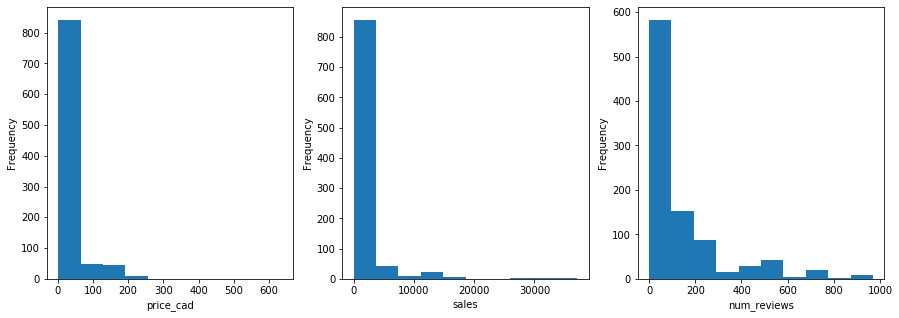

In [33]:
#PLOT NUMERICAL COLUMNS
fig=plt.figure(figsize=(15,5))
for i,j in enumerate(numerical):
    ax = plt.subplot(1,3,i+1)
    df[j].plot.hist(ax=ax,bins=10)
    ax.set_xlabel(j)
plt.show()

In [77]:
#FIND TOP 10 MATERIALS
allmaterials = ' '.join(df.material.apply(lambda x: x + ','))
freq = [i.strip() for i in freq = allmaterials.split(',')]
topmaterials = pd.Series(freq).value_counts()[:10]
topmaterials

No info            360
nylon              254
paracord           114
plastic             74
stainless steel     70
polyester           58
550 paracord        54
bronze              47
brass               39
buckle              32
dtype: int64

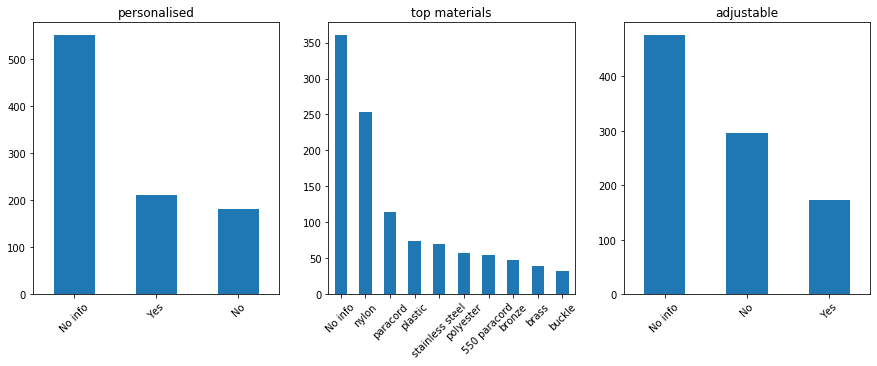

In [122]:
#PLOT CATEGORICAL COLUMNS
fig = plt.figure(figsize=(15,5))

ax1 = plt.subplot(1,3,1)
df.personalised.value_counts().plot.bar(ax=ax1, title = 'personalised',rot=45)

ax2 = plt.subplot(1,3,2)
topmaterials.plot.bar(ax=ax2,title = 'top materials',rot=45)

ax3 = plt.subplot(1,3,3)
df.adjustable.value_counts().plot.bar(ax=ax3, title = 'adjustable',rot=45)

plt.show()

### 2. Explore sellers

In [140]:
seller_info = df.groupby('seller').mean()

In [162]:
seller_info.describe()

,price_cad,sales,num_reviews
count,257.000000,257.000000,257.000000
mean,24.680847,1473.206226,98.731518
std,26.853565,4221.278465,170.276917
min,1.740000,0.000000,0.000000
25%,10.435000,17.000000,2.000000
50%,16.690000,160.000000,24.000000
75%,28.060000,1171.000000,117.000000
max,209.583333,37141.000000,969.000000


In [ ]:
seller_info.plot.bar

In [178]:
#top 10 sellers with highest average price
seller_info.sort_values('price_cad',ascending=False)[:10]

,price_cad,sales,num_reviews
seller,,,
ARHAIKAua,209.583333,744.0,152
ValhallaParacord,170.398750,951.0,213
THREEBRCLT,166.895385,274.0,58
ALEXPEDITION,123.605200,1236.0,231
RedrockByKandaurov,115.357500,273.0,68
UniqueHistoryShop,111.562500,14691.0,3
Cetus550,107.110000,175.0,30
RighteousByDesign,105.250000,6.0,1
HelenMurParacord,104.330000,1.0,0


In [157]:
#top 10 sellers with highest sales
seller_info.sort_values('sales',ascending=False)[:10]

,price_cad,sales,num_reviews
seller,,,
SweetAspenJewels,18.190000,37141.0,6
Fanfarria,12.475000,30889.0,4
MakeaWishXO,20.870000,27052.0,3
LateNightLuna,20.990000,17825.0,2
DCArtandPhotography,13.360000,17652.0,3
MAWXO,20.900000,15506.0,1
UniqueHistoryShop,111.562500,14691.0,3
FordsCordandMore,25.713333,12932.0,1
EMSALERTS,36.660000,10085.0,1


In [158]:
#top 10 sellers with highest number of reviews
seller_info.sort_values('num_reviews',ascending=False)[:10]

,price_cad,sales,num_reviews
seller,,,
ArcticSummit,36.797143,4178.0,969
GSJewelry,27.120000,4968.0,942
PawlowskiCreations,6.680000,6675.0,829
madewithloveinaiaciu,31.070000,4150.0,806
BeadUpStudio,7.990000,5151.0,710
ArtEngravingStudio,17.390000,6897.0,677
MrsBeesEmporium,36.255000,5972.0,658
LGGiftsandGoodies,17.460000,5551.0,658
ParacordInspirations,12.389474,2713.0,572


### 4. Description Analysis

#### Description Length

In [179]:
df['des_length'] = df.description.apply(lambda x: len(str(x).split()))

In [186]:
df.des_length.describe()

count     944.000000
mean      148.947034
std       158.474205
min         3.000000
25%        52.000000
50%        97.000000
75%       190.000000
max      1007.000000
Name: des_length, dtype: float64

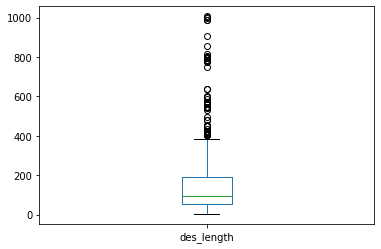

In [188]:
df.des_length.plot.box()

In [189]:
#average description length of top 50 products
top50 = df.sort_values(['sales','num_reviews','des_length'],ascending=False)[:50]

In [192]:
top50.des_length.describe()

count      50.000000
mean      498.080000
std       324.200042
min         8.000000
25%       261.250000
50%       456.000000
75%       795.000000
max      1007.000000
Name: des_length, dtype: float64

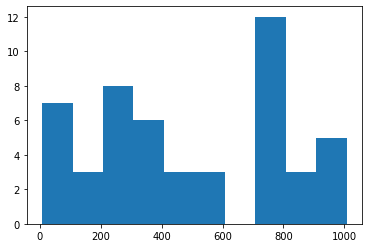

In [195]:
plt.hist(top50.des_length);

#### Preprocessing

In [196]:
#remove punctuation
import string 
def remove_punc(text):
    no_punct = "".join([i for i in text if (i not in string.punctuation)])
    return no_punct

In [197]:
no_punct = df.description.str.lower().apply(remove_punc).str.strip()

In [199]:
#lemmatization
from nltk.stem import WordNetLemmatizer
from collections import defaultdict
from nltk.corpus import wordnet as wn
from nltk.tag import pos_tag

lemmatizer = WordNetLemmatizer()
tag_map = defaultdict(lambda: wn.NOUN)
tag_map['J'] = wn.ADJ
tag_map['V'] = wn.VERB
tag_map['R'] = wn.ADV

In [200]:
def lemma_text(text):
    lemma = []
    for token, tag in pos_tag(text.split()):
        lemma1 = lemmatizer.lemmatize(token,tag_map[tag[0]])
        lemma.append(lemma1)
    return lemma

In [201]:
lemma = no_punct.apply(lemma_text)

In [202]:
lemma[0:5]

0    [zero, by, blacksquirrel, be, an, ultraminimal...
1    [covid19, announcement, the, current, global, ...
2    [durable, and, rugged, enough, for, the, outdo...
3    [stylish, paracord, bracelethandmadea, must, h...
4    [video, game, character, dragon, paracord, bra...
Name: description, dtype: object

In [203]:
# remove non-words
words = set(nltk.corpus.words.words())

def remove_non_words(text):
    print(text)
    return [' '.join(w for w in text if w in words)]

In [206]:
no_non_words = lemma.apply(remove_non_words)

['zero', 'by', 'blacksquirrel', 'be', 'an', 'ultraminimal', 'bracelet', 'to', 'be', 'use', 'in', 'your', 'everyday', 'although', 'it', 'be', 'make', 'in', 'different', 'size', 'thanks', 'to', 'a', 'particular', 'sliding', 'knot', 'you', 'can', 'tighten', 'it', 'or', 'enlarge', 'it', 'a', 'you', 'wish', 'so', 'you', 'can', 'find', 'the', 'perfect', 'fitbeing', 'adjustable', 'it', 'be', 'an', 'excellent', 'gift', 'idea', 'when', 'you', 'do', 'not', 'know', 'the', 'wrist', 'size', 'of', 'the', 'person', 'to', 'whom', 'the', 'bracelet', 'will', 'go', 'the', 'bracelet', 'be', 'handmade', 'in', 'our', 'artisan', 'workshop', 'in', 'italy', 'the', 'bracelet', 'be', 'in', 'paracord', '550', 'with', 'over', '50', 'color', 'availablechoose', 'the', 'right', 'gift', 'blacksquirrel', 'clip', 'your', 'freedomall', 'blacksquirrel', 'accessory', 'be', 'make', 'in', 'italy', 'by', 'hand', 'and', 'on', 'commission', 'once', 'we', 'receive', 'your', 'order', 'we', 'will', 'make', 'a', 'taylor', 'make', '

In [207]:
# remove stopwords
from nltk.corpus import stopwords
def remove_stopwords(text):
    return [w for w in text[0].split() if w not in stopwords.words('english')]

In [208]:
no_sw = no_non_words.apply(remove_stopwords)

In [209]:
no_sw[:5]

0    [zero, bracelet, use, everyday, although, make...
1    [announcement, current, global, pandemic, may,...
2    [durable, rugged, enough, outdoors, stylish, e...
3                   [stylish, must, message, question]
4    [video, game, character, dragon, make, custom,...
Name: description, dtype: object

#### Identify common topics using LDA

In [210]:
#LDA with Gensim
#https://towardsdatascience.com/topic-modelling-in-python-with-nltk-and-gensim-4ef03213cd21
from gensim import corpora
dictionary = corpora.Dictionary(no_sw)
corpus = [dictionary.doc2bow(text) for text in no_sw]

import pickle
pickle.dump(corpus, open('corpus.pkl', 'wb'))
dictionary.save('dictionary.gensim')

In [211]:
import gensim
NUM_TOPICS = 10
ldamodel = gensim.models.ldamodel.LdaModel(corpus, num_topics = NUM_TOPICS, id2word=dictionary, passes=15)
ldamodel.save('model5.gensim')
topics = ldamodel.print_topics(num_words=4)
for topic in topics:
    print(topic)

(0, '0.048*"line" + 0.031*"thin" + 0.025*"red" + 0.018*"blue"')
(1, '0.040*"bracelet" + 0.039*"measure" + 0.038*"wrist" + 0.029*"make"')
(2, '0.046*"bracelet" + 0.018*"please" + 0.016*"gift" + 0.013*"make"')
(3, '0.044*"wrist" + 0.038*"bracelet" + 0.026*"size" + 0.024*"measurement"')
(4, '0.049*"bracelet" + 0.024*"make" + 0.017*"size" + 0.017*"please"')
(5, '0.031*"bracelet" + 0.028*"contact" + 0.023*"brass" + 0.019*"please"')
(6, '0.033*"bracelet" + 0.028*"make" + 0.021*"handmade" + 0.021*"different"')
(7, '0.061*"bracelet" + 0.034*"wrist" + 0.032*"size" + 0.032*"inch"')
(8, '0.028*"order" + 0.020*"bracelet" + 0.020*"image" + 0.018*"engrave"')
(9, '0.046*"bracelet" + 0.024*"make" + 0.019*"size" + 0.018*"use"')


#### Most common words

In [212]:
allwords = ' '.join(no_sw.apply(lambda x: ' '.join(x)))
freq = pd.Series(allwords.split()).value_counts()[:20]
freq

bracelet       2967
wrist          1616
make           1518
size           1357
please         1101
color           919
measure         876
use             846
order           755
measurement     594
inch            522
fit             500
add             427
cord            426
choose          375
length          375
would           363
string          363
item            361
tape            343
dtype: int64

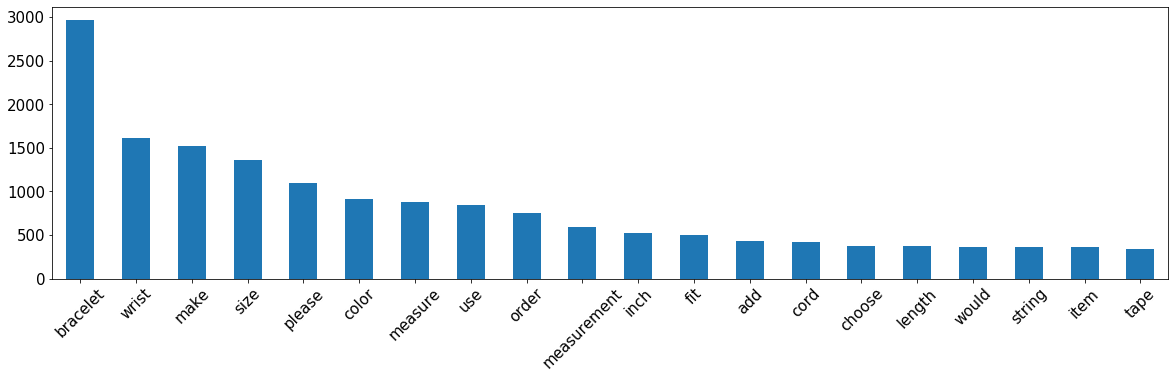

In [219]:
plt.figure(figsize=(20,5))
freq.plot.bar(rot=45,fontsize=15)

### 5. Header Analysis

#### Word Cloud

In [220]:
#wordcloud
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator

In [221]:
header1 = df.header.str.lower().apply(lambda x: x + ' ')

In [222]:
header1 = ''.join(list(flatten(header1))).replace('paracord','').replace('bracelet','')

In [224]:
# remove punctuation
header2 = remove_punc(header1)

In [225]:
#split long words
def split_long_word(text):
    split = [['paracord'] if i == 'paracord' else wordninja.split(i) for i in text.split()]
    return list(flatten(split))

In [226]:
header3 = ' '.join(split_long_word(header2))

In [227]:
#lemmatization
import nltk
from nltk.stem.wordnet import WordNetLemmatizer

header4 = []
for i in header3.split():
    header4.append(WordNetLemmatizer().lemmatize(i))
header4 = ' '.join(header4)

In [228]:
#wordcloud
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
wordcloud = WordCloud(width = 800, height = 400, background_color="white",max_words= 50).generate(header4)

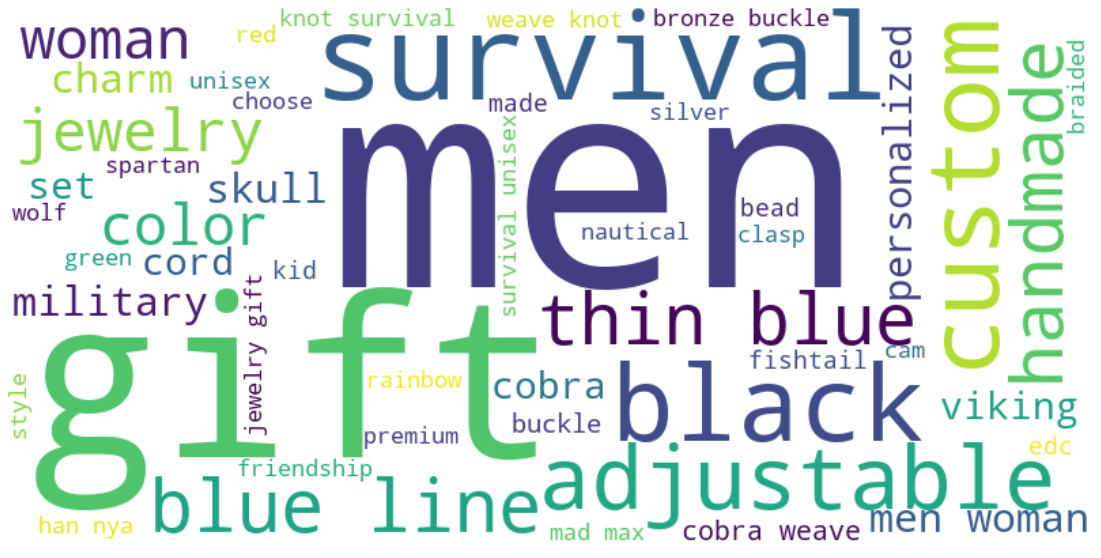

In [229]:
plt.figure(figsize=(20,10))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

In [141]:
plt.savefig('wordcloud.png', facecolor='k', bbox_inches='tight')

<Figure size 432x288 with 0 Axes>

#### Top 50 words in header with the most occurence

In [240]:
temp = [i for i in header3.split() if len(i) > 2]

In [242]:
pd.Series(temp).value_counts(ascending=False)[:50]

with            183
survival        172
gift            172
for             149
men             134
thin            123
line            122
mens            116
and             108
black            97
blue             93
custom           86
jewelry          85
cobra            83
adjustable       75
knot             71
cord             65
handmade         59
viking           57
charm            57
buckle           56
him              55
the              54
color            53
women            52
red              46
unisex           45
gifts            41
weave            39
550              39
colors           38
skull            37
military         37
bronze           35
brass            33
bead             33
personalized     33
exclusive        32
kids             31
fishtail         31
premium          30
her              29
edc              29
spartan          28
braid            28
white            28
green            26
man              26
friendship       24
made             24
